In [ ]:
# import
import os
import random
import subprocess
import warnings
from glob import glob
from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from matplotlib import animation
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_colwidth", 30)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(font_scale=1.2)
sns.set_style("ticks")
plt.rcParams["svg.fonttype"] = "none"
pd.set_option("display.max_columns", 30)

fe = fm.FontEntry(
    fname="/home/hzhou1/font/fonts/Helvetica/Helvetica.ttc", name="helvetica_new"
)
fm.fontManager.ttflist.insert(0, fe)
mpl.rcParams["font.family"] = "helvetica_new"
plt.rc("axes", unicode_minus=False)

np.set_printoptions(suppress=True)

# paths
path_main = "/home/hzhou1/targets_select/"
path_proj = "/home/hzhou1/"

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# Define a dictionary to map each ROI from one state to another, in two separate groups.
roi_mapping1 = {
    "37 24hr | 003 | Full ROI": "37 24hr | 007 | Full ROI",
    "37 24hr | 014 | Full ROI": "37 24hr | 018 | Full ROI",
    "37 24hr | 015 | Full ROI": "37 24hr | 019 | Full ROI",
    "38 24hr | 002 | Full ROI": "38 24hr | 006 | Full ROI",
    "38 24hr | 003 | Full ROI": "38 24hr | 007 | Full ROI",
    "38 24hr | 014 | Full ROI": "38 24hr | 018 | Full ROI",
}

roi_mapping2 = {
    "37 24hr | 007 | Full ROI": "37 24hr | 011 | Full ROI",
    "37 24hr | 018 | Full ROI": "37 24hr | 022 | Full ROI",
    "37 24hr | 019 | Full ROI": "37 24hr | 023 | Full ROI",
    "38 24hr | 006 | Full ROI": "38 24hr | 010 | Full ROI",
    "38 24hr | 007 | Full ROI": "38 24hr | 011 | Full ROI",
    "38 24hr | 018 | Full ROI": "38 24hr | 022 | Full ROI",
}

# Create two DataFrames from these mappings.
pairs_of_rois1 = pd.DataFrame(list(roi_mapping1.items()), columns=["A", "B"])
pairs_of_rois2 = pd.DataFrame(list(roi_mapping2.items()), columns=["A", "B"])

# Concatenate the two DataFrames to get a single DataFrame.
pairs_of_rois = pd.concat([pairs_of_rois1, pairs_of_rois2])


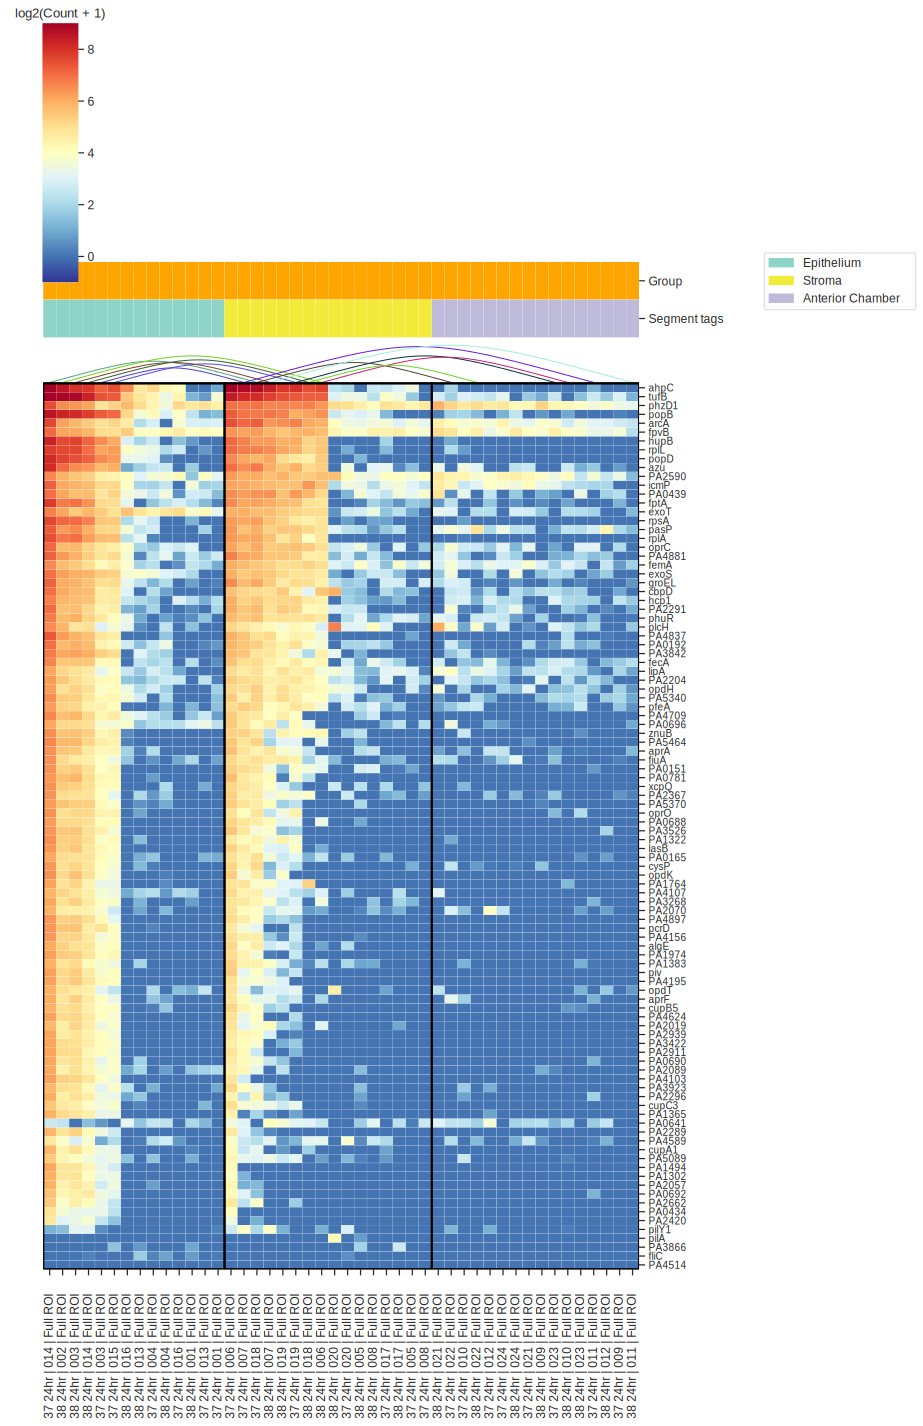

In [ ]:
# Get the Set3 colormap object
cmap = plt.get_cmap('Set3')

hex_codes = []
# Print the hexadecimal codes for each color in the colormap
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # Get the RGB values of the color
    hex_codes.append('#{:02x}{:02x}{:02x}'.format(*[int(x * 255) for x in rgb]))  # Convert RGB to hex
    
from matplotlib.path import Path
import matplotlib.patches as patches

sns.set(font_scale=1.1)
sns.set_style("ticks")

meta_select = meta[meta.Group.isin(["WT_PA"])][["Group", "Segment tags"]]
meta_select["Segment tags"] = pd.Categorical(
    meta_select["Segment tags"],
    categories=["Epithelium", "Stroma", "Anterior Chamber"],
    ordered=True,
)
meta_select = meta_select.sort_values(["Group", "Segment tags"])

# Create toplot DataFrame using the sorted meta_select index
toplot = df_dsp_back_ba[meta_select.index]

# Create color maps for the Group and Segment tags columns
lut = dict(zip(["WT_PA"], ["orange"]))
col_colors = meta_select[["Group"]].loc[toplot.columns].Group.map(lut)

lut2 = dict(
    zip(["Epithelium", "Stroma", "Anterior Chamber"], [hex_codes[0]] + ['#F3EB3A'] + [hex_codes[2]])
)
col_colors2 = (
    meta_select[["Segment tags"]].loc[toplot.columns]["Segment tags"].map(lut2)
)

col_colors = pd.concat([col_colors, col_colors2], axis=1)

# Create separate heatmaps for each combination of Group and Segment tags
heatmaps = []

for group in ["WT_PA"]:
    for segment in ["Epithelium", "Stroma", "Anterior Chamber"]:
        meta_subset = meta_select[
            (meta_select["Group"] == group) & (meta_select["Segment tags"] == segment)
        ]
        toplot_subset = df_dsp_back_ba[meta_subset.index]

        if not toplot_subset.empty:
            # Sort columns by mean value
            toplot_subset = toplot_subset.loc[
                :, toplot_subset.mean().sort_values(ascending=False).index
            ]

            heatmap_subset = sns.clustermap(
                np.log2(toplot_subset + 1),
                cmap="RdBu_r",
                linewidth=0.01,
                col_cluster=False,
                row_cluster=False,
                yticklabels=True,
                xticklabels=True,
                # dendrogram_ratio=(0, 0.3),
            )
            heatmaps.append(heatmap_subset)
            plt.close(heatmap_subset.fig)  # Close the figure for the individual heatmap

# Combine the heatmaps and plot them
combined_heatmap = pd.DataFrame()
combined_meta = pd.DataFrame()

for i, heatmap in enumerate(heatmaps):
    if i == 0:
        combined_heatmap = heatmap.data2d
        combined_meta = meta_select.loc[heatmap.data2d.columns]
    else:
        combined_heatmap = pd.concat([combined_heatmap, heatmap.data2d], axis=1)
        combined_meta = pd.concat(
            [combined_meta, meta_select.loc[heatmap.data2d.columns]], axis=0
        )

col_colors_combined = pd.concat(
    [
        combined_meta[["Group"]].Group.map(lut),
        combined_meta[["Segment tags"]]["Segment tags"].map(lut2),
    ],
    axis=1,
)

# Plot the combined heatmap with the correct values
# Define the colors in the palette
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.path import Path
import matplotlib.patches as patches

colors = [(0, 0, 1), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)

cluster = sns.clustermap(
    np.log2(df_dsp_back_ba[combined_meta.index] + 1),
    figsize=(14, 20),
    cmap='RdYlBu_r',
    linewidth=0.1,
    fmt=".1f",
    col_cluster=False,
    row_cluster=True,
    yticklabels=True,
    xticklabels=False,
    col_colors=col_colors,
    # dendrogram_ratio=(0, 0.2),
    vmin=-1,
    vmax=8,
    metric = 'cityblock'
)

plt.close(cluster.fig)

# Get the clustered row indices
clustered_row_indices = cluster.dendrogram_row.reordered_ind

# Reverse the order of the clustered row indices
reversed_row_indices = clustered_row_indices[::-1]

# Reorder the DataFrame based on the reversed row indices
reversed_clustered_df = df_dsp_back_ba[combined_meta.index].sort_index().iloc[reversed_row_indices]

#sort by mean values of each targets 
tosort = df_dsp_back_ba.mean(axis = 1).sort_values(ascending = False).index

# Plot the clustermap with the reversed row order
cluster = sns.clustermap(
    np.log2(reversed_clustered_df.loc[tosort] + 1),
    figsize=(10, 20),
    cmap='RdYlBu_r',
    linewidth=0.1,
    fmt=".1f",
    col_cluster=False,
    row_cluster=False,  # Set row_cluster to False since we already have the reversed row order
    yticklabels=True,
    xticklabels=True,
    col_colors=col_colors,
    dendrogram_ratio=(0, 0.2),
    vmin=-1,
    vmax=9,
    metric='cityblock',
    cbar_kws={'shrink': 1},
    edgecolor = 'lightgrey'
)

cbar = cluster.ax_heatmap.collections[0].colorbar
cbar.ax.set_title("log2(Count + 1)")

group_legend = [
    Patch(facecolor=lut["WT_PA"], edgecolor=lut["WT_PA"], label="WT_PA"),
    Patch(facecolor=lut["KO_PA"], edgecolor=lut["KO_PA"], label="KO_PA"),
]

segment_legend = [
    Patch(facecolor=lut2["Epithelium"], edgecolor=lut2["Epithelium"], label="Epithelium"),
    Patch(facecolor=lut2["Stroma"], edgecolor=lut2["Stroma"], label="Stroma"),
    Patch(facecolor=lut2["Anterior Chamber"], edgecolor=lut2["Anterior Chamber"], label="Anterior Chamber"),
]

# # Remove the title for the Group and Segment legends
cluster.ax_col_colors.legend(
    handles=group_legend, title="", bbox_to_anchor=(1.2, 0.85), loc="upper left"
)
cluster.ax_col_colors.legend(
    handles=segment_legend, title="", bbox_to_anchor=(1.2, 1.2), loc="upper left"
)

# add connections
key_item_dict = {key: value for key, value in zip(pairs_of_rois['A'], pairs_of_rois['B'])}
x_labels = combined_meta.index.tolist()

def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

def create_bezier_curve(ax, start, end, control, lw=1, color='black', linestyle='-'):
    # Remove the old control point calculation
    # curve_factor = distance * 0.12  # adjust this factor to control the curve
    # control = ((start[0] + end[0]) / 2, start[1] - curve_factor)
    
    path_data = [
        (Path.MOVETO, start),
        (Path.CURVE4, control),
        (Path.CURVE4, control),
        (Path.CURVE4, end),
    ]
    codes, verts = zip(*path_data)
    path = Path(verts, codes)
    color = generate_random_color()
    patch = patches.PathPatch(path, lw=lw, edgecolor=color, facecolor='none', linestyle=linestyle)
    ax.add_patch(patch)
    ax.plot()

positions = {}
for key, value in key_item_dict.items():
    
    positions[key] = x_labels.index(str(key))
    positions[value] = x_labels.index(str(value))

    start = (positions[key]+0.5, -0.1)
    end = (positions[value]+0.5, -0.1)

    control = ((start[0] + end[0]) / 2, start[1] - abs(start[0] - end[0]) * 0.2)
    
    create_bezier_curve(cluster.ax_heatmap, start, end, control, lw=1, color='black', linestyle='-')

cluster.ax_heatmap.collections[0].set_zorder(-1)
cluster.ax_heatmap.set_ylim([100, -5])

unique_groups = col_colors['Segment tags'].unique()
group_positions = []

for group in unique_groups:
    indices = [i for i, value in enumerate(col_colors['Segment tags']) if value == group]
    group_positions.append((min(indices), max(indices)))

for min_idx, max_idx in group_positions:
    rect = patches.Rectangle((min_idx, -0), max_idx-min_idx+1, len(df_dsp_back_ba),
                             linewidth=2, edgecolor='black', facecolor='none', linestyle='-')
    cluster.ax_heatmap.add_patch(rect)

unique_groups = col_colors['Group'].unique()
group_positions = []

for group in unique_groups:
    indices = [i for i, value in enumerate(col_colors['Group']) if value == group]
    group_positions.append((min(indices), max(indices)))

for min_idx, max_idx in group_positions:
    rect = patches.Rectangle((min_idx, -0), max_idx-min_idx+1, len(df_dsp_back_ba), linewidth=2, edgecolor='black', facecolor='none', linestyle='-')
    cluster.ax_heatmap.add_patch(rect)
    
# Set the font size for y-axis tick labels
y_font_size = 10  # Adjust this value to change the font size
for tick_label in cluster.ax_heatmap.get_yticklabels():
    tick_label.set_fontsize(y_font_size)
cluster.ax_heatmap.set_ylabel('')

plt.show()